# Differential Dynamic Microscopy

Cerbino, R. & Trappe, V. Differential dynamic microscopy: Probing wave vector dependent dynamics with a microscope. Phys. Rev. Lett. 100, 1–4 (2008).

## Import libraries

In [99]:
%matplotlib inline

import os
import cv2
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from matplotlib.pylab import subplot
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from matplotlib.widgets import SpanSelector
from tqdm.auto import tqdm
from scipy.optimize import leastsq
from typing import List


# Set environment variables for OpenCV
os.environ['OPENCV_LOG_LEVEL'] = 'FATAL'
os.environ['OPENCV_FFMPEG_LOGLEVEL'] = "-8"

## Import video

Add information about the video here.

In [100]:
video_file = "./Data/0.75micron_150fps_3sec_new.avi" # Change this to the name of the video file you want to analyse
pixelSize = 0.229 #micrometere/pixel(in micrometre)

### Image stack

We will create a stack containing all of the frames of the video. The frame in postision `t` can be retrieved using `stack[t]`. 

In [101]:
class ImageStack:
    def __init__(self, filename: str, channel=None):
        self.filename = filename

        # load the video file in a cv2 object
        self.video = cv2.VideoCapture(filename)

        if not self.video.isOpened():
            raise ValueError('File path likely incorrect, failed to open.')

        property_id = int(cv2.CAP_PROP_FRAME_COUNT)

        # get the number of frames
        self.frame_count = int(self.video.get(property_id))
        # get the fps
        self.fps = self.video.get(cv2.CAP_PROP_FPS)
        # store the specified colour channel (if any)
        self.channel = channel

        # read first frame to determine the shape (keep original shape)
        self.video.set(cv2.CAP_PROP_POS_FRAMES, 0)
        self.shape = self[0].shape

    def __len__(self):
        return self.frame_count
            
    def __getitem__(self, t):
        if t < 0: t= len(self) + t - 1  # Handle negative indices
        assert t < self.frame_count  # Check if the index is within the range
        self.video.set(cv2.CAP_PROP_POS_FRAMES, t - 1)  # Set the position of the video to the desired frame
        success, image = self.video.read()  # Read the frame

        if self.channel is not None:
            return image[...,self.channel]  # Return the specified channel of the frame
        if image is not None:
            return image.mean(axis=2).astype(int)  # Return the grayscale version of the frame
        self.shape = self[0].shape  # Get the shape of the first frame
    
    def pre_load_stack(self):
        """Load all frames into a numpy array which is pickleable."""
        # load the first frame to determine whether it is RGB or grayscale
        first_frame = self[0]

        # handle grayscale or RGB frames (2 or 3 dimensions)
        if len(first_frame.shape) == 2:  # Grayscale
            frames = np.zeros((self.frame_count, *first_frame.shape), dtype=np.uint8)
        elif len(first_frame.shape) == 3:  # RGB
            frames = np.zeros((self.frame_count, *first_frame.shape), dtype=np.uint8)
        else:
            raise ValueError(f"Unsupported frame shape: {first_frame.shape}")

        # load all frames into the pre-constructed array
        for i in range(self.frame_count):
            frames[i] = self[i]
        return frames
    
    def verify_frames(self):
        """Verifies that the frames stored in preloaded_stack match those from the stack object."""

        # Load the preloaded stack
        preloaded_stack = self.pre_load_stack()

        # Loop through each frame and verify the data
        for i in range(self.frame_count):
            # Compare the corresponding frames in the preloaded stack and the stack
            if not np.array_equal(preloaded_stack[i], self[i]):
                print(f"Frames at index {i} do not match!")
                return False
        
        print("All frames match correctly.")
        return True


In [102]:
class ImageStackOriginal(object):
    def __init__(self, filename, channel = None):
        # Initialize the ImageStack object
        self.filename = filename
        self.video = cv2.VideoCapture(filename)  # Open the video file
        property_id = int(cv2.CAP_PROP_FRAME_COUNT)  
        length = int(self.video.get(property_id))  # Get the number of frames in the video
        self.frame_count = length  # Store the number of frames
        self.fps = self.video.get(cv2.CAP_PROP_FPS)  # Get the frames per second of the video
        self.channel = channel  # Store the specified channel
        self.shape = self[0].shape

    def __len__(self):
        return self.frame_count  # Return the number of frames in the video
            
    def __getitem__(self, t):
        if t<0: t= len(self)+t-1  # Handle negative indices
        assert t < self.frame_count  # Check if the index is within the range
        self.video.set(cv2.CAP_PROP_POS_FRAMES, t-1)  # Set the position of the video to the desired frame
        success, image = self.video.read()  # Read the frame

        if self.channel is not None:
            return image[...,self.channel]  # Return the specified channel of the frame
        if image is not None:
            return image.mean(axis=2).astype(int)  # Return the grayscale version of the frame
        self.shape = self[0].shape  # Get the shape of the first frame


Create the image stack for the video.

Show the first and last frame, and the difference between the two.

All frames match correctly.


Text(0.5, 1.0, 'Difference')

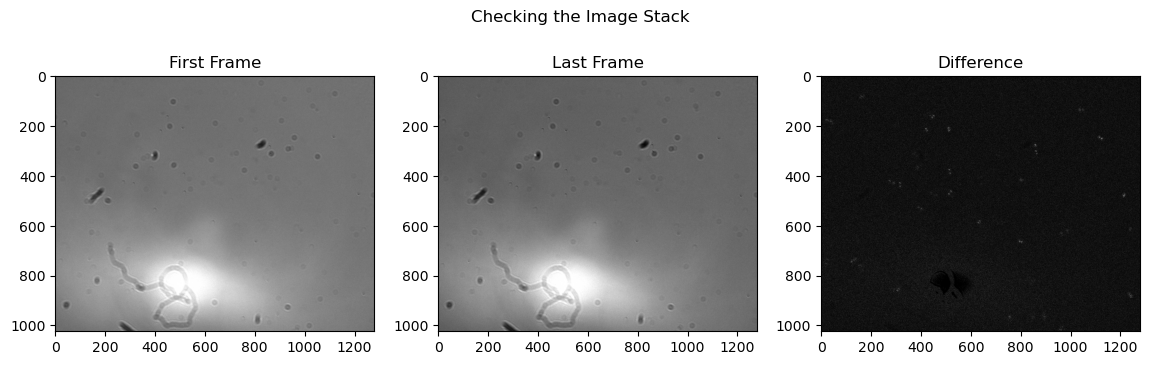

In [103]:
stack = ImageStack(video_file)
preloaded_stack = stack.pre_load_stack()

stack.verify_frames()

plt.figure(figsize=(14,4))
plt.suptitle('Checking the Image Stack')
subplot(1,3,1).imshow(stack[0], 'gray')
subplot(1,3,1).set_title('First Frame')
subplot(1,3,2).imshow(stack[-1], 'gray')
subplot(1,3,2).set_title('Last Frame')
subplot(1,3,3).imshow(np.abs(stack[-1] - stack[0]).astype(float), 'gray')
subplot(1,3,3).set_title('Difference')

## Functions to calculate the Image Structure Function (ISF)

* First, we calculate the frame difference between the two frames $t$ and $t + \tau$ ($\tau$ is the lag time).
* Then we Fourier transform (in 2-dimensions).
* Next we square the modulus of the result.
$$\left|\widehat{\Delta I}\right|^2(\vec{q}, t, \tau) = \left|\mathcal{F}\left[I(\vec{x}, t+\tau) - I(\vec{x}, t)\right]\right|^2$$
where $I(\vec{x}, t)$ is the intensity of the image at time $t$ at position $\vec{x}$ and $\mathcal{F}$ is the 2D Fourier transform.

In [104]:
def spectrumDiff(im0, im1):
    """
    Computes squared modulus of 2D Fourier Transform of difference between im0 and im1
    Args:
        im0: matrix type object for frame at time t
        im1: matrix type object for frame at time t + tau
    """
    return np.abs(np.fft.fft2(im1-im0.astype(float)))**2

Show resulting spectra for $\tau=$ 0.1 s, 1 s, 10s

Text(0.5, 1.0, 'tau = 2.1s')

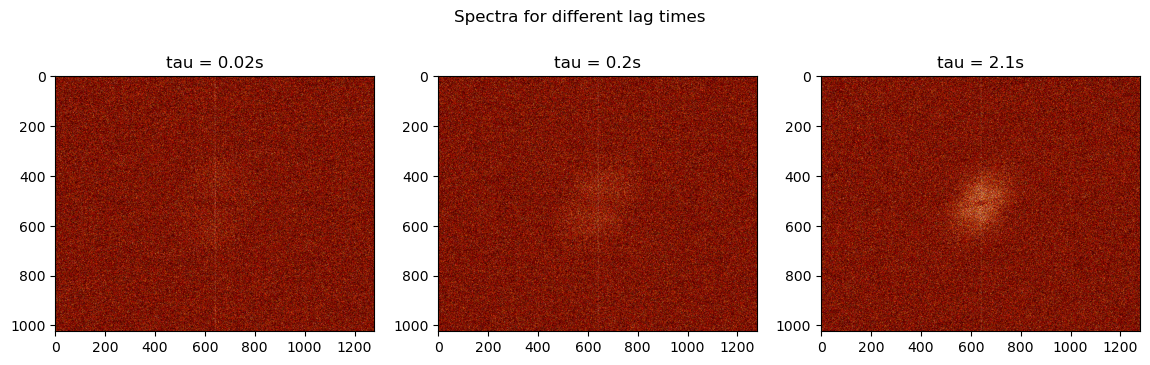

In [105]:
plt.figure(figsize=(14,4))
plt.suptitle('Spectra for different lag times')

# find 99th percentile frequency max_v
max_v = np.percentile(np.fft.fftshift(spectrumDiff(stack[0], stack[3])),99)

# produce 3 heat maps (dark is low frequency, light is high frequency)
frame_count = stack.frame_count
fps = stack.fps

subplot(1,3,1).imshow(np.fft.fftshift(spectrumDiff(stack[0], stack[3])), 'hot',vmin=0, vmax=max_v)
subplot(1,3,1).set_title(f'tau = {round(3 / fps, 2)}s')
subplot(1,3,2).imshow(np.fft.fftshift(spectrumDiff(stack[0], stack[30])), 'hot',vmin=0, vmax=max_v)
subplot(1,3,2).set_title(f'tau = {round(30 / fps, 2)}s')
subplot(1,3,3).imshow(np.fft.fftshift(spectrumDiff(stack[0], stack[-1])), 'hot',vmin=0, vmax=max_v)
subplot(1,3,3).set_title(f'tau = {round((frame_count - 1) / fps, 2)}s')

A single couple of images is not enough to get good statistics - we need more spectra.

For a fixed time interval `dt`, we take at most `maxNCouples` couples of images evenly spead in the available range of times and average over time.

In [106]:
def timeAveraged(frames: np.ndarray, dframes: int, maxNCouples: int=20):
    """
    Does at most maxNCouples spectreDiff on regularly spaced couples of images. 
    Args:
        frames: numpy array of frames loaded in advance
        dframes: interval between frames (integer)
        maxNCouples: maximum number of couples to average over
    """
    # create array of initial times (the 'im0' in spectrumDiff) of length maxNCouples AT MOST
    # evenly spaced in increments of 'increment'
    increment = max([(frames.shape[0] - dframes) / maxNCouples, 1])
    initialTimes = np.arange(0, frames.shape[0] - dframes, increment)

    avgFFT = np.zeros(frames.shape[1:])
    failed = 0
    for t in initialTimes:
        t = np.floor(t).astype(int)

        im0 = frames[t]
        im1 = frames[t+dframes]
        if im0 is None or im1 is None:
            failed +=1
            continue
        avgFFT += spectrumDiff(im0, im1)
    return avgFFT / (initialTimes.size - failed)


def timeAveraged_old(stack, dt, maxNCouples=20):
    """Does at most maxNCouples spectreDiff on regularly spaced couples of images. 
    Separation within couple is dt."""
    #Spread initial times over the available range
    increment = max([(len(stack)-dt)/maxNCouples, 1])
    initialTimes = np.arange(0, len(stack)-dt, increment)
    #perform the time average
    avgFFT = np.zeros(stack.shape)
    failed = 0
    for t in initialTimes:
        im0 = stack[t]
        im1 = stack[t+dt]
        if im0 is None or im1 is None:
            failed +=1
            continue
        avgFFT += spectrumDiff(im0, im1)
    return avgFFT / (len(initialTimes)-failed)

dframes = 5
maxNCouples = 10

original_stack = ImageStackOriginal(video_file)

new_avg = timeAveraged(preloaded_stack, dframes, maxNCouples)
old_avg = timeAveraged_old(stack, dframes, maxNCouples)
original_avg = timeAveraged_old(original_stack, dframes, maxNCouples)

same = np.array_equal(new_avg, old_avg)
print(same)



True


Show the resulting time-averaged spectra for $dt = 3,30,300$ with maximum five couples.

Text(0.5, 1.0, 'Time Average (dt = 2.1s)')

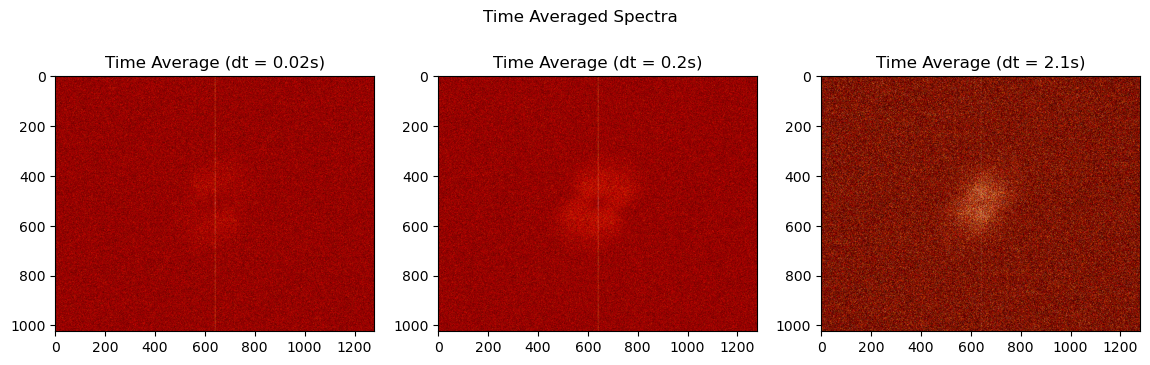

In [107]:
plt.figure(figsize=(14,4))
plt.suptitle('Time Averaged Spectra')

# create numpy array of frames
# preloaded_stack = stack.pre_load_stack()

timeAverage_3 = timeAveraged(preloaded_stack, 3, 5)
timeAverage_30 = timeAveraged(preloaded_stack, 30, 5)
timeAverage_300 = timeAveraged(preloaded_stack, frame_count - 1, 5)

subplot(1,3,1).imshow(np.fft.fftshift(timeAverage_3), 'hot',vmin=0, vmax=max_v)
subplot(1,3,1).set_title(f'Time Average (dt = {round(3 / fps, 2)}s)')
subplot(1,3,2).imshow(np.fft.fftshift(timeAverage_30), 'hot',vmin=0, vmax=max_v)
subplot(1,3,2).set_title(f'Time Average (dt = {round(30 / fps, 2)}s)')
subplot(1,3,3).imshow(np.fft.fftshift(timeAverage_300), 'hot',vmin=0, vmax=max_v)
subplot(1,3,3).set_title(f'Time Average (dt = {round((frame_count - 1) / fps, 2)}s)')

Next, we need to calculate the radial average of the spectra, as we assume the dynamics are isotropic.

Also, since some spectra have anomalously bright cross, we do not take this line and this column into account.

In [108]:
class RadialAverager(object):
    """Radial average of a 2D array centred on (0,0), like the result of fft2d."""
    def __init__(self, shape):
        """A RadialAverager instance can process only arrays of a given shape, fixed at instanciation."""
        assert len(shape)==2
        #matrix of distances
        self.dists = np.sqrt(np.fft.fftfreq(shape[0])[:,None]**2 +  np.fft.fftfreq(shape[1])[None,:]**2)
        #dump the cross
        self.dists[0] = 0
        self.dists[:,0] = 0
        #discretize distances into bins
        self.bins = np.arange(max(shape)/2+1)/float(max(shape))
        #number of pixels at each distance
        self.hd = np.histogram(self.dists, self.bins)[0]
    
    def __call__(self, im):
        """Perform and return the radial average of the specrum 'im'"""
        assert im.shape == self.dists.shape
        hw = np.histogram(self.dists, self.bins, weights=im)[0]
        return hw/self.hd

Text(0.5, 1.0, 'Radial Average of the Time Averaged Spectrum')

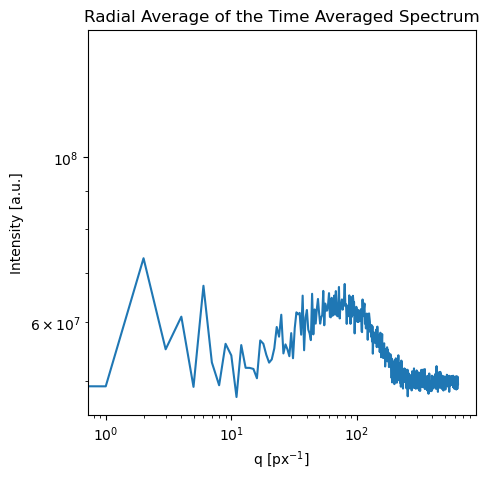

In [109]:
plt.figure(figsize=(5,5))

# ra is now a callable function which performs the Radial Averaging on a 2D array of a fourier transform
ra = RadialAverager(stack.shape)

# for example, perform ra on the timeAverage between 1st and 30th frame
plt.plot(ra(timeAverage_30))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('q [px$^{-1}$]')
plt.ylabel('Intensity [a.u.]')
plt.title('Radial Average of the Time Averaged Spectrum')

We won't perform all those steps for every time interval, it would be too time consuming. So we sample time intervals logarithmically.

In [110]:
def logSpaced(L: float, pointsPerDecade: int=15) -> List[int]:
    """Generate an array of log spaced integers smaller than L"""
    nbdecades = np.log10(L)
    return np.unique(np.logspace(
        start=0, stop=nbdecades, 
        num=int(nbdecades * pointsPerDecade), 
        base=10, endpoint=False
        ).astype(int))

Finally, we put everything together to obtain 
$$ISF(\tau,q) = \left\langle \left|\widehat{\Delta I}\right|^2 (\vec{q}, t, \tau)\right\rangle$$ 
were $\langle.\rangle$ is the average at initial time $t$ and the orientation of $\vec{q}$.

Since this can be a long operation, we add a counter.

In [111]:
def calculate_isf_original(stack, idts, maxNCouples=1000):
    """Perform time averaged and radial averaged DDM for given time intervals.
    Returns isf"""
    ra = RadialAverager(stack.shape)
    isf = np.zeros((len(idts), len(ra.hd)))
    for i, idt in tqdm(enumerate(idts), total=len(idts)):
        isf[i] = ra(timeAveraged(stack, idt, maxNCouples))
    return isf

def calculate_isf(stack: ImageStack, preloaded_stack: np.ndarray, idts: List[float], maxNCouples: int = 1000, n_jobs=-1) -> np.ndarray:
    """
    Perform time-averaged and radial-averaged DDM for given time intervals.
    Returns ISF (Intermediate Scattering Function).

    Args:
        stack: ImageStack object (from cv2.VideoCapture)
        preloaded_stack: numpy array of frames (required for pickling)
        idts: List of integer rounded indices (within range) to specify
              which frames to time-average between
        maxNCouples: Maximum number of pairs to perform time averaging over
        n_jobs: Number of parallel jobs to run (set to -1 for all cores)
    """
    # create instance of radial averager callable
    ra = RadialAverager(stack.shape)
    
    # parallelise the time averaging
    with Parallel(n_jobs=n_jobs, backend='threading') as parallel:
        time_avg_results = parallel(delayed(timeAveraged)(preloaded_stack, idt, maxNCouples) for idt in idts)

    # parallelize the radial averaging
    with Parallel(n_jobs=n_jobs, backend='threading') as parallel:
        isf = np.array(parallel(delayed(ra)(ta) for ta in time_avg_results))

    return isf


## Analysing your video

We will now analyse your video.

If you want to try another video, you will need to change the video file information at the top of the script, but then you can continue here.

### Calculate the ISF

In [112]:
# number of points to sample between each power of 10 in time intervals
pointsPerDecade = 30

# recommended values: 10 for speed, 300 for accuracy
maxNCouples = 10

# generate list of indices log spaced
idts = logSpaced(stack.frame_count, pointsPerDecade)

# converting the idts list of indices back to continuous time
dts = idts / stack.fps
ISF = calculate_isf(stack, preloaded_stack, idts, maxNCouples)

Calculate the scale of wavenumbers $q$. Set the longest time index fit.

In [113]:
qs = 2*np.pi/(2*ISF.shape[-1]*pixelSize) * np.arange(ISF.shape[-1])
tmax = -1

Display the ISF

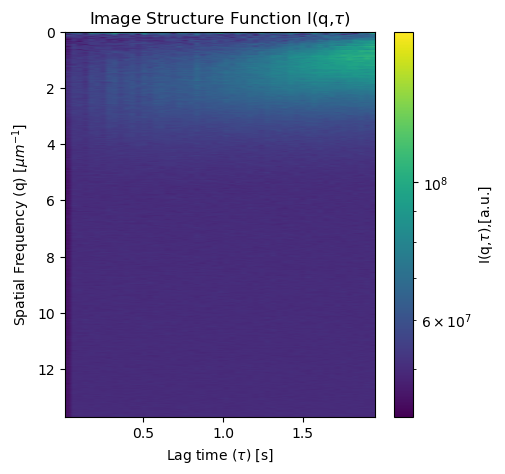

In [114]:
plt.figure(figsize=(5,5))
ISF_transposed = np.transpose(ISF)
plt.imshow(ISF_transposed, cmap='viridis', aspect='auto', extent=[dts[0], dts[-1], qs[-1], qs[0]], norm=LogNorm())
plt.colorbar(label='I(q,$\\tau$),[a.u.]')
plt.title('Image Structure Function I(q,$\\tau$)')
plt.xlabel('Lag time ($\\tau$) [s]')
plt.ylabel('Spatial Frequency (q) [$\\mu m ^{-1}$]')
plt.show()

## Fitting the ISF

Now we fit our ISF to the model.

Remember that the general form of the ISF is:

$$ISF(\tau,q) = A(q)[1-f(\tau,q)] + B(q)$$

* $A(q)$: Contributions from optics and static structures.
* $B(q)$: Camera noise
* $f(\tau,q)$: Correlation function (system dynamics)

All the information about the system dynamics is in $f(\tau, q)$. In some simple cases - such as the one we are studying today - it can be obtained analytically.

We will define the correlation function necessary for the expected system dynamics - for today, *either* Brownian motion *or* ballistic motion.

### Correlation function for Brownian motion

For an homogenous sample of colloids undergoing simple Brownian motion, the theory says the correlation function is: 

$$f(\tau,q) = \exp\left(\frac{-\tau}{\tau_c(q)}\right)$$

where $\tau_c$ is the characteristic decay time.

In [115]:
LogISF = lambda p, dts: np.log(np.maximum(p[0] * (1 - np.exp(-dts / p[2])) + p[1], 1e-10))

### Correlation function for ballistic motion

For an homogeneous sample of colloids undergoing ballistic motion, the theory says the correlation function is:

$$f(\tau,q) = \frac{\sin\left(\frac{\tau}{\tau_c(q)}\right)}{\frac{\tau}{\tau_c(q)}}$$

where $\tau_c$ is the characteristic decay time.

In [116]:
#LogISF = lambda p, dts: np.log(p[0] * (1-(np.sin(dts/p[2])/(dts/p[2]))) + p[1]) 

### Perform the ISF fitting

Perform the fit at each $q$ and generate the values of the fitted function.



Knowing the analytical form of $f(\tau, q)$ allow us to fit the ISF one Fourier Mode at a time, leaving $A$ and $B$ as free parameters.


You may encounter some RuntimeWarnings, but we can ignore them for now.

In [117]:
import numpy as np

params = np.zeros((ISF.shape[-1], 3))
matrixfit = np.zeros(ISF[:tmax].T.shape)
for iq, ddm in enumerate(ISF[:tmax].T):
    params[iq] = leastsq(
        # function to minimize
        lambda p, dts, logd: LogISF(p, dts) - logd,
        # initial parameters
        [np.ptp(ISF), ddm.min(), 1],
        # data on which to perform minimization
        args=(dts[:tmax], np.log(ddm))
    )[0]
    # Ensure non-negative values
    matrixfit[iq] = np.exp(LogISF(params[iq], dts[:tmax]))

C:\Users\Demonstrators\AppData\Local\Temp\ipykernel_16960\1473574676.py:1: RuntimeWarning: overflow encountered in exp
  LogISF = lambda p, dts: np.log(np.maximum(p[0] * (1 - np.exp(-dts / p[2])) + p[1], 1e-10))
C:\Users\Demonstrators\AppData\Local\Temp\ipykernel_16960\1473574676.py:1: RuntimeWarning: overflow encountered in multiply
  LogISF = lambda p, dts: np.log(np.maximum(p[0] * (1 - np.exp(-dts / p[2])) + p[1], 1e-10))
C:\Users\Demonstrators\AppData\Local\Temp\ipykernel_16960\2031436528.py:6: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  params[iq] = leastsq(


## Assess the ISF fits

Select the region of q where the fit will be valid.

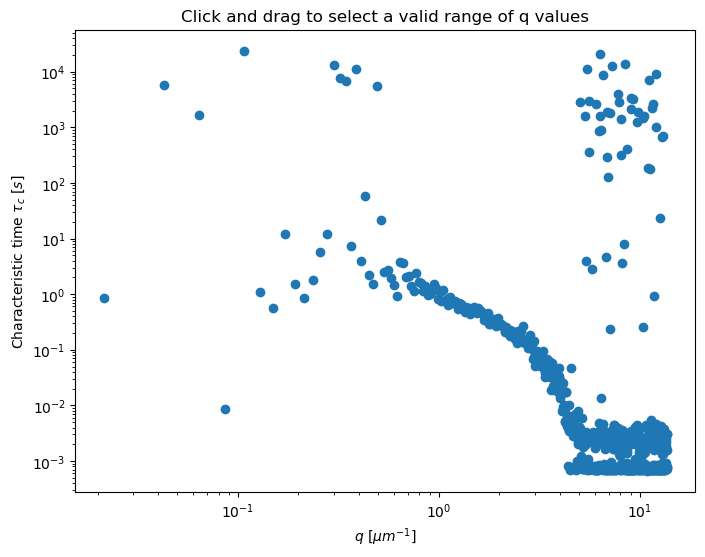

In [118]:
def onselect(xmin, xmax):
    global iqmin, iqmax
    iqmin= np.searchsorted(qs, xmin)
    iqmax = np.searchsorted(qs, xmax)
    print(f"Selected range: {qs[iqmin]:.2f} to {qs[iqmax]:.2f}")

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(qs, params[:, 2], 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$q\ [\mu m^{-1}$]')
ax.set_ylabel(r'Characteristic time $\tau_c\ [s]$')
ax.set_title('Click and drag to select a valid range of q values')

span = SpanSelector(ax, onselect, 'horizontal', useblit=True, interactive=True, props=dict(alpha=0.5, facecolor='red'))
plt.show()

In [119]:
# Only use if you want to select the range of q manually

iqmin = np.where(qs > 1)[0][0]
iqmax = np.where(qs < 3)[0][-1]

Show parameters $A(q)$ and $B(q)$

(1000.0, 100000000000.0)

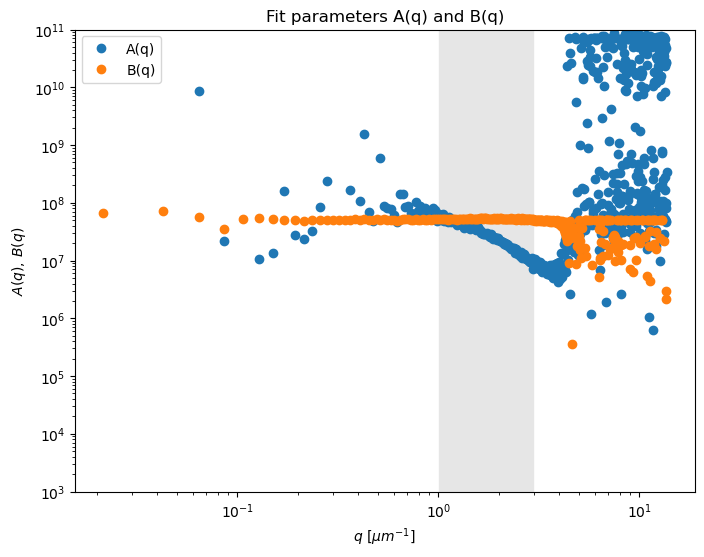

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.title('Fit parameters A(q) and B(q)')
plt.plot(qs, params[:,0], 'o', label="A(q)")
plt.plot(qs, params[:,1], 'o', label="B(q)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$q\ [\mu m^{-1}]$')
plt.ylabel(r'$A(q),\, B(q)$')

plt.axvspan(qs[iqmin], qs[iqmax], color=(0.9,0.9,0.9))
plt.legend()
plt.ylim((1e3,1e11))


Show the results of the fit function $f(\tau,q)$ of $q$ for various $\tau$ and function of $\tau$ for various $q$.

(10, 100000.0)

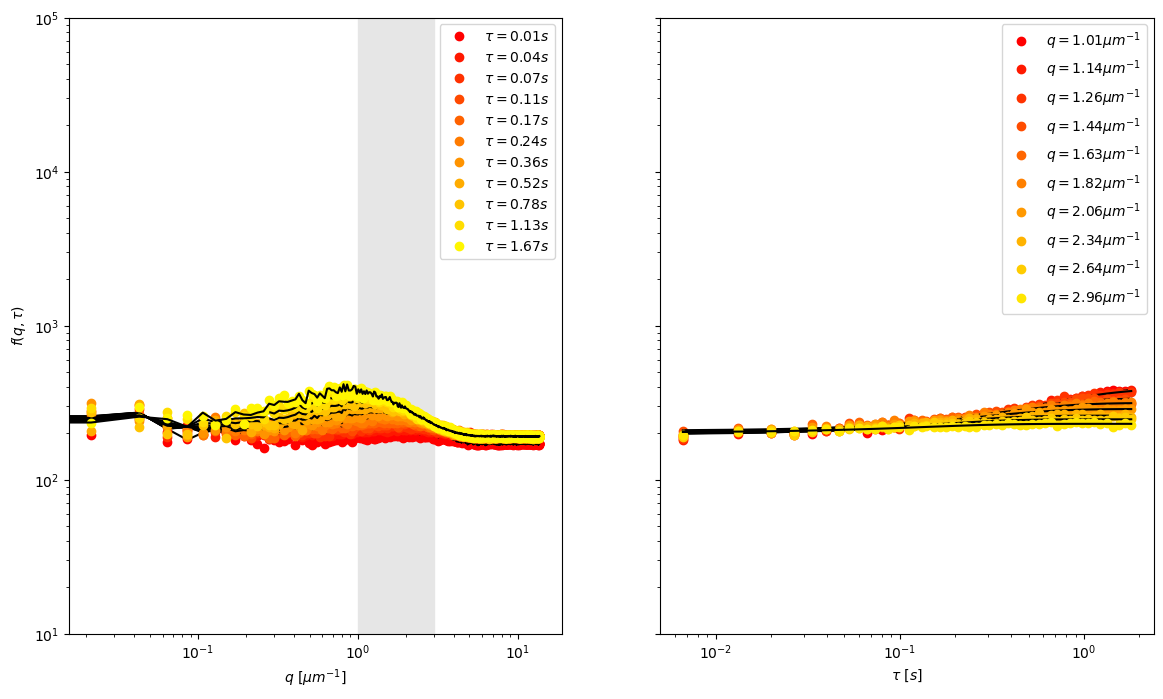

In [121]:
plt.figure(figsize=(14,8))
ax1 = subplot(1,2,1)
for i in range(0,len(dts[:tmax]),5):
    plt.plot(qs, ISF[i]/512**2, 'o', color=cm.autumn(i/float(len(dts[:tmax]))),label = f'$\\tau = {round(dts[i], 2)}s$')
    plt.plot(qs, matrixfit[:,i]/512**2, '-k')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$f(q,\tau)$')
plt.xlabel(r'$q\ [\mu m^{-1}]$')
plt.axvspan(qs[iqmin], qs[iqmax], color=(0.9,0.9,0.9))
plt.legend()

ax2 = subplot(1,2,2, sharey=ax1)
for i,iq in enumerate(np.logspace(np.log10(iqmin),np.log10(iqmax),10, base=10).astype(int)):
    plt.plot(dts[:tmax], ISF[:tmax,iq]/512**2, 'o', color=cm.autumn(i/10.),label=f'$q = {round(qs[iq], 2)} \\mu m^{{-1}}$')
    plt.plot(dts[:tmax], matrixfit[iq]/512**2, '-k')
plt.xscale('log')
plt.xlabel(r'$\tau\ [s]$')
plt.setp(ax2.get_yticklabels(), visible=False)
plt.legend()
plt.ylim(10, 1e5)

The corresponding ISF for various $q$ functions of $\tau$ or, to show the Brownian rescaling, function of $q^2\tau$.

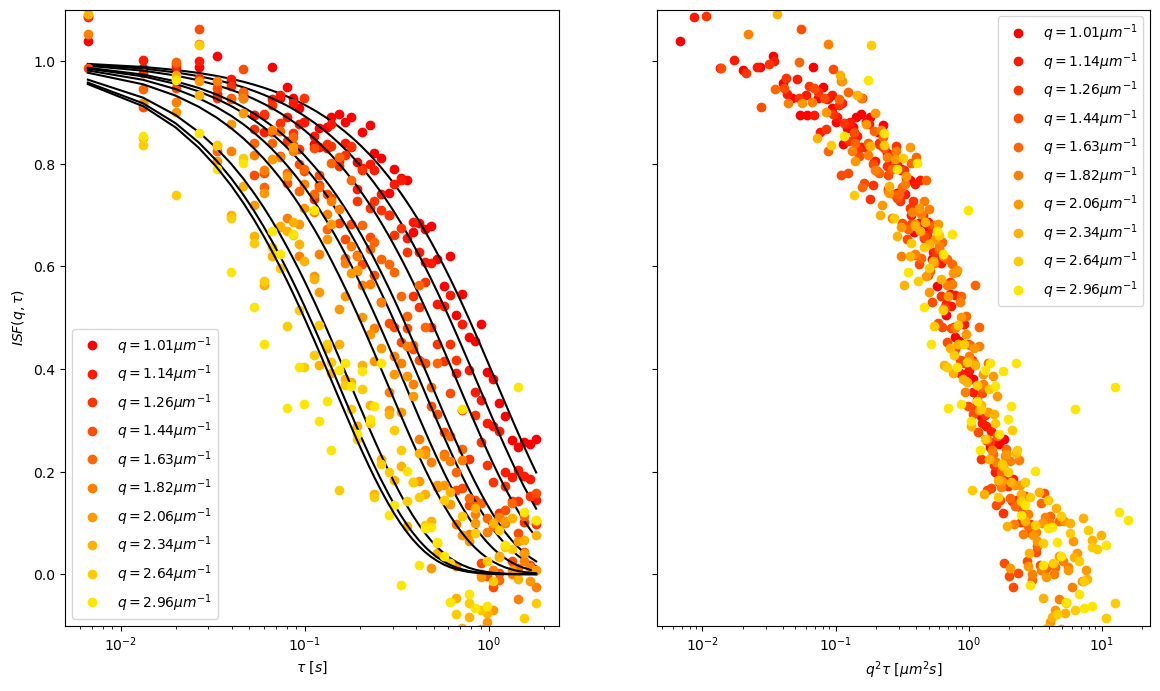

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))
ax1 = plt.subplot(1,2,1)
for i,iq in enumerate(np.logspace(np.log10(iqmin),np.log10(iqmax),10, base=10).astype(int)):
    plt.plot(dts[:tmax], 1- (ISF[:tmax,iq]-params[iq,1])/params[iq,0], 'o', color=cm.autumn(i/10.), label=f'$q = {round(qs[iq], 2)}\\mu m^{{-1}}$')
    plt.plot(dts[:tmax], np.exp(-dts[:tmax]/params[iq,2]), '-k')
plt.xscale('log')
plt.ylabel(r'$ISF(q,\tau)$')
plt.xlabel(r'$\tau\ [s]$')
plt.legend()

ax2 = subplot(1,2,2, sharey=ax1)
for i,iq in enumerate(np.logspace(np.log10(iqmin),np.log10(iqmax),10, base=10).astype(int)):
    ax2.plot(qs[iq]**2*dts[:tmax], 1- (ISF[:tmax,iq]-params[iq,1])/params[iq,0], 'o', color=cm.autumn(i/10.),label=f'$q = {round(qs[iq], 2)}\\mu m^{{-1}}$')
ax2.set_xscale('log')
ax2.set_xlabel(r'$q^2\tau\ [\mu m^2s]$')
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_ylim(-0.1,1.1)
ax2.legend()

## Fit the characteristic time

### Free exponent

In the scenarios we are looking at today, from the theory we can expect there to be a power law relationship between the characteristic time $\tau_c$ and the spatial frequency $q$. This relationship depends on the behaviour of the colloids but is of the form:
$$\tau_c(q) = \frac{1}{Xq^\alpha}$$
where $X$ is a coefficient which charaterises the colloid diffusion (described below for each type of behaviour) and $\alpha$ is a free exponent. 

For Brownian motion: $\alpha = 2$  
For ballistic motion: $\alpha = 1$

We therefore fit the characteristic time $\tau_c(q)$ against $\frac{1}{q^\alpha}$ and to obtain the coefficient $D$ and the free exponent $\alpha$. This will help us know what whether the colloid motion is Brownian or ballistic.

alpha = 2.01
X = 0.93


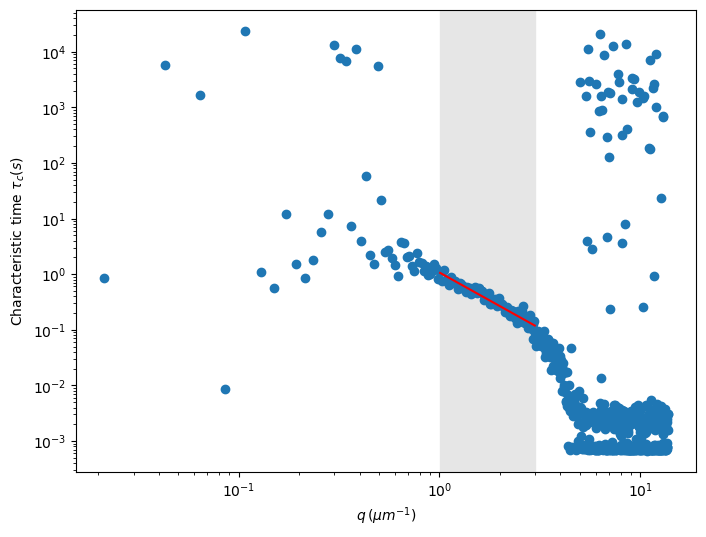

In [123]:
plt.figure(figsize=(8,6))
plt.plot(qs, params[:,2], 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$q\,(\mu m^{-1})$')
plt.ylabel(r'Characteristic time $\tau_c (s)$')
plt.axvspan(qs[iqmin], qs[iqmax], color=(0.9,0.9,0.9))

X, alpha = leastsq(
    lambda p, q, td: p[0] - p[1]*np.log(np.abs(q)) - np.log(np.abs(td)),
    [1,2],
    args=(qs[iqmin:iqmax], params[iqmin:iqmax,2])
    )[0]
X= np.exp(-X)
plt.plot([qs[iqmin], qs[iqmax]], 1/(X*np.array([qs[iqmin], qs[iqmax]])**alpha), '-r')
print(f"alpha = {alpha:.02f}")
print(f"X = {X:.02f}")

### Brownian motion

From the theory - for Brownian motion(random walk) - we can expect:

$$\tau_c(q) = \frac{1}{Dq^2}$$

where $D$ is the diffusion coefficient ($[D] = [L^2][T^{{-1}}]$).

We therefore fit the characteristic time $\tau_c(q)$ against $\frac{1}{q^2}$ and to obtain the diffusion coefficient $D$.


D = 0.94 µm²/s


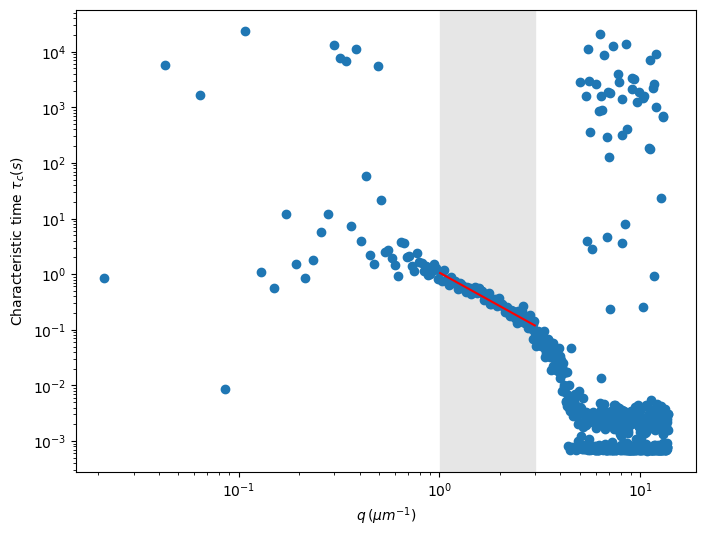

In [124]:
plt.figure(figsize=(8,6))
plt.plot(qs, params[:,2], 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$q\,(\mu m^{-1})$')
plt.ylabel(r'Characteristic time $\tau_c (s)$')
plt.axvspan(qs[iqmin], qs[iqmax], color=(0.9,0.9,0.9))
D = np.exp(-leastsq(
    lambda p, q, td: p[0] - 2*np.log(q) - np.log(td),
    [-1.],
    args=(qs[iqmin:iqmax], params[iqmin:iqmax,2])
    )[0][0])
plt.plot([qs[iqmin], qs[iqmax]], 1/(D*np.array([qs[iqmin], qs[iqmax]])**2), '-r')
print(f"D = {D:.02f} µm²/s")


Test it against the theoretical value using the Stokes-Einstein equation:

$$ D = \frac{k_B T}{3 \pi \mu a} $$

where:
- $ D $ is the diffusion coefficient,
- $ k_B $ is the Boltzmann constant,
- $ T $ is the absolute temperature,
- $ \mu $ is the dynamic viscosity,
- $ a $ is the diameter of the spherical particle.



In [125]:
kB = 1.38e-23
T = 300
mu = 8.9e-4
a = 0.75e-6 #change this to the diameter of the particle in metres

D_theory = kB*T/(3*np.pi*mu*a) * 1e12
print(f"D theory = {D_theory:.02f} µm²/s")

D theory = 0.66 µm²/s


Or estimate the size of the particles using the calculated diffusion coefficient.

In [126]:
predicted_a = kB*T/(3*np.pi*mu*D) *1e12*1e6
print(f"Diameter = {predicted_a:.02f} µm")

Diameter = 0.52 µm


### Ballistic motion

From the theory - for ballistic motion - we can expect:
$$\tau_c = \frac{1}{\nu q}$$
where $\nu$ is the mean velocity of the colloids.
We therefore fit the characteristic time $\tau_c(q)$ against $\frac{1}{q}$ and to obtain the mean velocity $\nu$.

v = 1.78 µm²/s


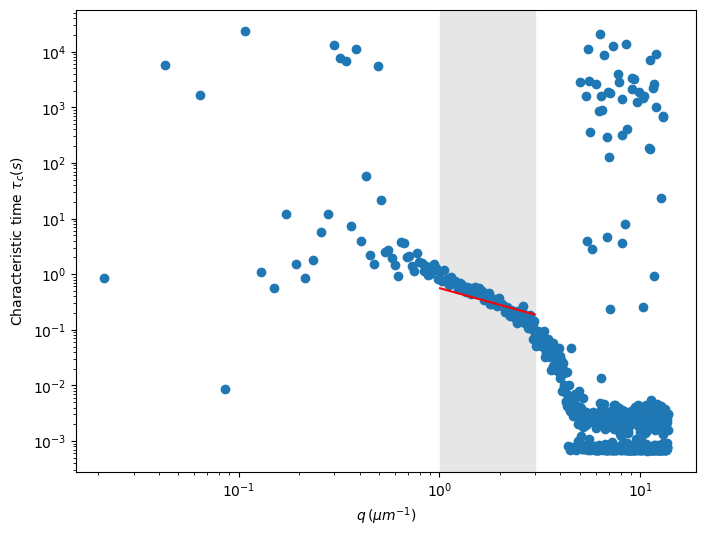

In [127]:
plt.figure(figsize=(8,6))
plt.plot(qs, params[:,2], 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$q\,(\mu m^{-1})$')
plt.ylabel(r'Characteristic time $\tau_c (s)$')
plt.axvspan(qs[iqmin], qs[iqmax], color=(0.9,0.9,0.9))

v = np.exp(-leastsq(
    lambda p, q, td: p - np.log(np.abs(q)) - np.log(np.abs(td)),
    [-1],
    args=(qs[iqmin:iqmax], params[iqmin:iqmax,2])
    )[0][0])
plt.plot([qs[iqmin], qs[iqmax]], 1/(v*np.array([qs[iqmin], qs[iqmax]])), '-r')
print(f"v = {v:.02f} µm²/s")

## Acknowledgements

Adapted from https://github.com/MathieuLeocmach/DDM.